In [360]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve,accuracy_score
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns


LR helper functions

In [361]:
dataframe=None
X_train = None
X_test = None
y_train = None
y_test = None
X_val = None
y_val = None

class LogisticRegression:
    def __init__(self,maxIteration,noFeatures,n_base_learners,learning_rate):
        self.maxIteration=maxIteration
        self.noFeatures=noFeatures
        self.theta = np.zeros((noFeatures,1))
        self.bias=0
        self.n_base_learners=n_base_learners
        self.learning_rate=learning_rate

    def sigmoid(self,z):
        z = np.array(z, dtype=float)
        return 1 / (1 + np.exp(-z))
    
    def logisticRegression(self,X,y):
        # print('hi')
        m=len(X)
        for iteration in range(self.maxIteration):
            # matrix multiplication
            h = self.sigmoid(np.dot(X,self.theta)+self.bias)
            gradient = np.dot(X.T,(h - y))/m
            db=np.sum(h-y)/m
            self.theta -= self.learning_rate * gradient
            self.bias -= self.learning_rate * db

    def predict(self,X):
        probabilities = self.sigmoid(np.dot(X,self.theta)+self.bias)
        predictions = [1 if prob >= 0.5 else 0 for prob in probabilities]
        return np.array(predictions)
    
    def output(self,X,predictions):
        y_test_np = y_test.flatten()

        # predictions = self.predict(X)
        # accuracy = np.mean(predictions == y_test_np)
        # print(f"Accuracy: {accuracy}")
        sensitivity = recall_score(y_test, predictions)
        print("Sensitivity/Recall: ", sensitivity)
        tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
        specificity = tn / (tn + fp)
        print("Specificity: ", specificity)
        precision = precision_score(y_test, predictions)
        print("Precision: ", precision)
        f1 = f1_score(y_test, predictions)
        print("F1 Score: ", f1)
        y_prob = self.sigmoid(np.dot(X,self.theta))
        auroc = roc_auc_score(y_test, y_prob)
        print("AUROC: ", auroc)
        precision_values, recall_values, _ = precision_recall_curve(y_test, y_prob)
        aupr = auc(recall_values, precision_values)
        print("AUPR: ", aupr)
    
    def train(self):
        self.logisticRegression(X_train,y_train)
        self.output()

def normalize(X):
    return (X - X.mean()) / X.std()



Preprocessing helpers

In [362]:
def scalingFunction(scaling='standard'):
    if scaling == 'standard':
        scaler = StandardScaler()
    elif scaling == 'minmax':
        scaler = MinMaxScaler()
    
    return scaler

def preprocessing(target_col_name):
    # drop null and fill null
    dataframe.dropna(subset=[target_col_name], inplace=True)
    dataframe.fillna(dataframe.mean(numeric_only=True),inplace=True)
    # fill null for non-numeric columns
    non_numerical_columns = dataframe.select_dtypes(include=['object']).columns
    for column in non_numerical_columns:
        mode_value = dataframe[column].mode()[0]
        dataframe[column].fillna(mode_value,inplace=True)
    # drop duplicates
    dataframe.drop_duplicates(inplace=True)
    # feature and target
    features=dataframe.drop(target_col_name,axis=1)
    target=dataframe[target_col_name]
    # label encoding the target
    encoder=LabelEncoder()
    target=encoder.fit_transform(target)
    # categorization and one-hot encoding
    categorical_columns=features.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        features[col]=features[col].astype('category')
    features=pd.get_dummies(features,columns=categorical_columns)
    # scaling
    candidate_columns=features.select_dtypes(exclude=['bool']).columns
    # scaler=scalingFunction('standard')
    scaler=scalingFunction('minmax')
    features_scaled=features.copy()
    features_scaled[candidate_columns]=scaler.fit_transform(features[candidate_columns])
    return features_scaled,target

def split(features, target):
    global X_train, X_test, y_train, y_test, X_val, y_val

    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    X_val = X_val.to_numpy()
    y_val = y_val.to_numpy()



Train with LR

In [363]:
def stacking(model_list,n_base_learners,learning_rate,maxIteration,noFeatures):
    meta_features = np.zeros((X_val.shape[0], n_base_learners))
    for i in range(n_base_learners):
        # Make predictions on the validation set using each base learner
        meta_features[:, i] = model_list[i].predict(X_val)
    print(meta_features.shape)
    # Step 3: Train a meta-model (another Logistic Regression) using the meta-features

    # Train the meta-model on meta-features and validation labels
    LR_meta_final=LogisticRegression(maxIteration,n_base_learners,n_base_learners,learning_rate)
    LR_meta_final.logisticRegression(meta_features,y_val)

    # Step 5: Make final predictions on the test set using the base learners and the meta-model
    # Generate meta-features from the test set
    meta_features_test = np.zeros((X_test.shape[0], n_base_learners))

    for i in range(n_base_learners):
        # Use each base learner to predict on the test set
        meta_features_test[:, i] = model_list[i].predict(X_test)

    # Make final predictions using the meta-model
    stacking_predictions = LR_meta_final.predict(meta_features_test)

    # Step 6: Evaluate the performance of the stacking ensemble
    stacking_accuracy = np.mean(stacking_predictions == y_test.flatten())

    print(f"Stacking Ensemble Accuracy: {stacking_accuracy}")
    LR_meta_final.output(meta_features_test,stacking_predictions)

In [364]:
def majority_voting(model_list):
    # Step 1: Collect predictions from each model in the model_list
    predictions = np.zeros((len(model_list), X_test.shape[0]))

    for i, model in enumerate(model_list):
        predictions[i, :] = model.predict(X_test)

    # Step 2: Perform majority voting
    final_predictions = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=0, arr=predictions)

    # Step 3: Evaluate performance
    y_test_flattened = y_test.flatten()
    voting_accuracy = np.mean(final_predictions == y_test_flattened)
    print(f"Majority Voting Ensemble Accuracy: {voting_accuracy}")
    sensitivity = recall_score(y_test_flattened, final_predictions)
    print(f"Sensitivity/Recall: {sensitivity}")
    tn, fp, fn, tp = confusion_matrix(y_test_flattened, final_predictions).ravel()
    specificity = tn / (tn + fp)
    print(f"Specificity: {specificity}")

    # Precision
    precision = precision_score(y_test_flattened, final_predictions)
    print(f"Precision: {precision}")

    # F1 Score
    f1 = f1_score(y_test_flattened, final_predictions)
    print(f"F1 Score: {f1}")

    # AUROC
    y_prob = np.mean([model.sigmoid(np.dot(X_test,model.theta)) for model in model_list], axis=0)  # Average the predicted probabilities
    auroc = roc_auc_score(y_test_flattened, y_prob)
    print(f"AUROC: {auroc}")

    # AUPR
    precision_values, recall_values, _ = precision_recall_curve(y_test_flattened, y_prob)
    aupr = auc(recall_values, precision_values)
    print(f"AUPR: {aupr}")


In [365]:
def bagging(n_base_learners,maxIteration,learning_rate):
    metrics_data = {
    "accuracy": [],
    "sensitivity": [],
    "specificity": [],
    "precision": [],
    "f1_score": [],
    "auroc": [],
    "aupr": []
    }
    model_list=[]
    noFeatures = X_train.shape[1]
    for i in range(n_base_learners):
        X_bootstrap, y_bootstrap = resample(X_train, y_train, random_state=i)
        X = X_bootstrap
        y = y_bootstrap.reshape(-1,1)
        # Initialize theta and bias for the current model
        theta = np.zeros((noFeatures, 1))
        bias = 0
        
        LR=LogisticRegression(maxIteration,noFeatures,n_base_learners,learning_rate)
        LR.logisticRegression(X_bootstrap,y_bootstrap)
        # Store the parameters (theta and bias) of the trained base learner
        model_list.append(LR)
        # LR.output()
        # Predict on test data
        model=model_list[-1]
        predictions = model.predict(X_test)
        y_test_flattened = y_test.flatten()

        # Accuracy
        accuracy = np.mean(predictions == y_test_flattened)
        metrics_data['accuracy'].append(accuracy)

        # Sensitivity/Recall
        sensitivity = recall_score(y_test_flattened, predictions)
        metrics_data['sensitivity'].append(sensitivity)

        # Specificity
        tn, fp, fn, tp = confusion_matrix(y_test_flattened, predictions).ravel()
        specificity = tn / (tn + fp)
        metrics_data['specificity'].append(specificity)

        # Precision
        precision = precision_score(y_test_flattened, predictions)
        metrics_data['precision'].append(precision)

        # F1 Score
        f1 = f1_score(y_test_flattened, predictions)
        metrics_data['f1_score'].append(f1)

        # AUROC
        y_prob = model.sigmoid(np.dot(X_test,model.theta))  # Probabilities for the positive class
        auroc = roc_auc_score(y_test_flattened, y_prob)
        metrics_data['auroc'].append(auroc)

        # AUPR
        precision_values, recall_values, _ = precision_recall_curve(y_test_flattened, y_prob)
        aupr = auc(recall_values, precision_values)
        metrics_data['aupr'].append(aupr)
    
    metrics_df = pd.DataFrame(metrics_data)

    # Plot violin plots for each metric
    plt.figure(figsize=(14, 8))

    # Create subplots for each performance metric
    for i, metric in enumerate(metrics_data.keys()):
        plt.subplot(2, 4, i+1)  # 2 rows, 4 columns of subplots
        sns.violinplot(data=metrics_df[metric])
        plt.title(f'{metric.capitalize()} Violin Plot')

    # Adjust layout
    plt.tight_layout()
    plt.show()
    stacking(model_list,n_base_learners,learning_rate,maxIteration,noFeatures)
    majority_voting(model_list)


In [366]:
# model = LogisticRegression(max_iter=maxIteration)
    # model.fit(X_train, y_train)
    # y_pred = model.predict(X_test_np)
    # print(accuracy_score(y_test,y_pred))

Read datasets

In [367]:
def read_2():
    global dataframe
    column_file = 'adult/adult.names'
    data_file = 'adult/adult.data'
    columns = []
    with open(column_file, 'r') as f:
        for line in f:
            if '|' not in line:  # Ignore lines starting with '|'
                if ':' in line:
                    # Extract the column name before the ':' punctuation mark
                    col_name = line.split(':')[0].strip()
                    columns.append(col_name)
    columns.append('income-exceeds')
    dataframe = pd.read_csv(data_file, header=None)
    # print(dataframe)
    dataframe.columns = columns
    # print(dataframe)
    dataframe.replace(' ?', np.nan, inplace=True)

def read(input):
    global dataframe
    target_col_name=None
    # file 1
    if input == 1:
        dataframe = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
        target_col_name='Churn'
    # file 2
    elif input == 2:
        read_2()
        target_col_name='income-exceeds'
    # file 3
    elif input == 3:
        dataframe = pd.read_csv('creditcard.csv')
        target_col_name='Class'
    else:
        print("Invalid input")
    features,target=preprocessing(target_col_name)
    features_df=pd.DataFrame(features,columns=features.columns)
    target_df=pd.DataFrame(target,columns=[target_col_name])
    features_df_normalized=normalize(features_df)
    split(features_df_normalized,target_df)
    LR=LogisticRegression(1000,features_df_normalized.shape[1],9,0.01)
    # LR.train()
    bagging(9,1000,0.01)


Input

C:\Users\hp\AppData\Local\Temp\ipykernel_13932\4255362103.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataframe[column].fillna(mode_value,inplace=True)


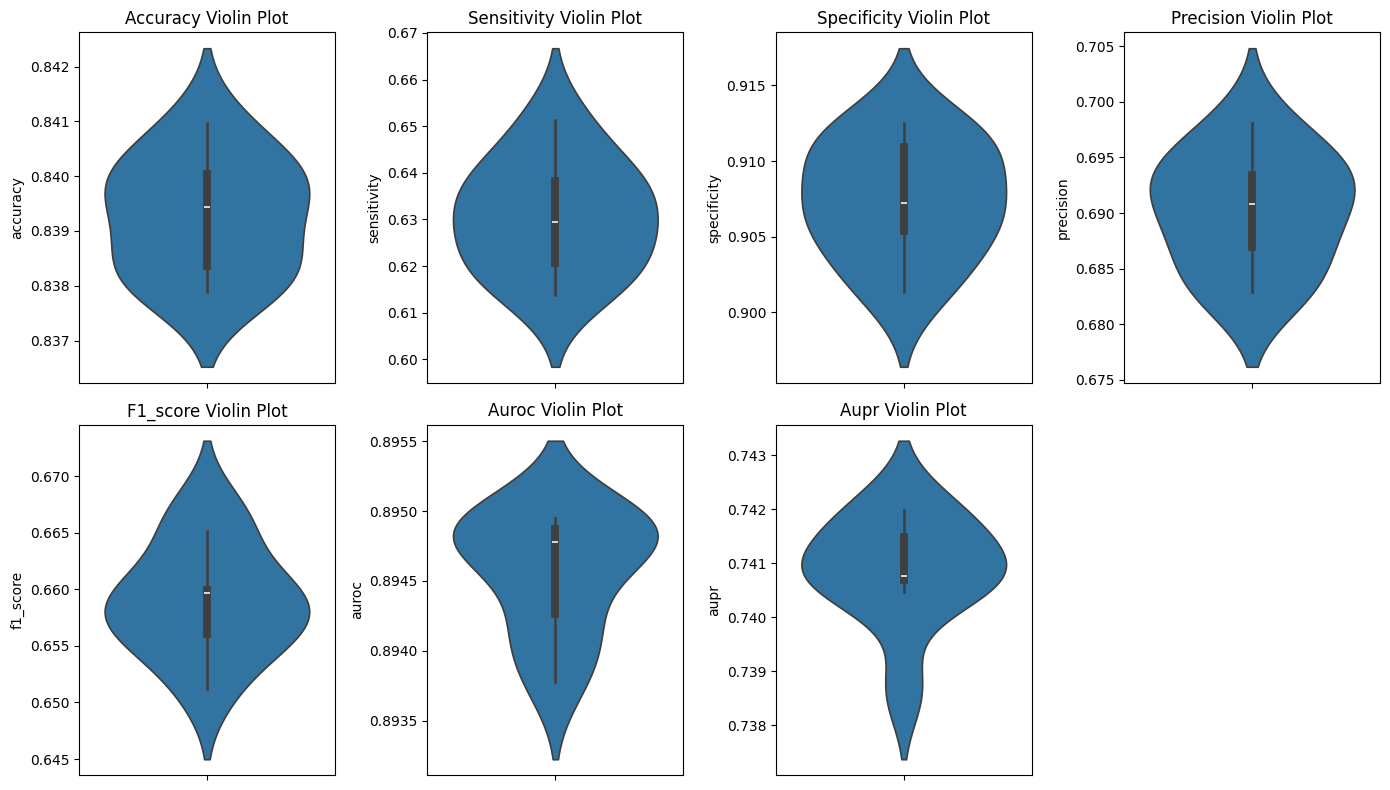

(5206, 9)
Stacking Ensemble Accuracy: 0.8409649661954518
Sensitivity/Recall:  0.6150966936993137
Specificity:  0.9147808358817533
Precision:  0.7022792022792023
F1 Score:  0.6558031260392417
AUROC:  0.7872897593261361
AUPR:  0.7120549940859151
Majority Voting Ensemble Accuracy: 0.8383527965580824
Sensitivity/Recall: 0.6263256394260761
Specificity: 0.9076452599388379
Precision: 0.6890871654083733
F1 Score: 0.6562091503267974
AUROC: 0.895317965868024
AUPR: 0.7427736270252177


In [368]:
user_input = int(input("Enter 1, 2 or 3: "))
read(user_input)